# OR Advent 2024 December 3: task assigning (Python)

## Assignment

Hey, ORville here

I'm a logistics manager overseeing the allocation of tasks to employees in our company, FurnitORe.

Right now we have 100 tasks that need to be completed, and we also have 100 employees available to handle them.

The catch is that assigning a task to an employee has a cost.

These costs vary depending on the difficulty of the task, the expertise of the employee, and other factors.

I need your help to figure out the most cost-effective way to assign these tasks to employees.

You can assume that each task is done by just one employee, and one employee is assigned to just one task.

Can you help me solve this problem?

## Notes

**This implementation requires Python 3.12, not 3.13.**

## Dependencies

This Jupyter Notebook solves an OR Advent problem with [Timefold Solver](https://timefold.ai/open-source-solver), the open source planning solver AI. We add it as a dependency:

In [1]:
pip install timefold==1.16.0b0

Note: you may need to restart the kernel to use updated packages.



## Domain

We need to assign tasks to employees:

In [2]:
from dataclasses import dataclass

@dataclass
class Employee:
    id: int

This class changes during planning. Timefold Solver fills in the `@PlanningVariable` annotated fields for all instances:

In [3]:
from timefold.solver.domain import (planning_entity, PlanningVariable, PlanningId)
from dataclasses import dataclass, field
from typing import (Annotated, Dict)

@planning_entity
@dataclass
class Task:
    id: Annotated[int, PlanningId]
    employee_cost_map: Dict[int, int] = field(default_factory=dict)
    employee: Annotated[Employee | None, PlanningVariable] = field(default=None)


    def calc_cost(self) -> int:
        if self.employee is None:
            return 0
        return self.employee_cost_map.get(self.employee.id)

## Constraints

The solver takes into account hard and soft constraints:

In [4]:
from timefold.solver.score import (constraint_provider, HardSoftScore, Joiners,
                                   ConstraintFactory, Constraint)

@constraint_provider
def define_constraints(constraint_factory: ConstraintFactory):
    return [
        # Hard constraints
        employee_conflict(constraint_factory),
        # Soft constraints
        minimize_cost(constraint_factory),
    ]


def employee_conflict(constraint_factory: ConstraintFactory) -> Constraint:
    return (constraint_factory
            .for_each_unique_pair(Task,
                                  Joiners.equal(lambda task: task.employee))
            .penalize(HardSoftScore.ONE_HARD)
            .as_constraint("Employee conflict"))


def minimize_cost(constraint_factory: ConstraintFactory) -> Constraint:
    return (constraint_factory
            .for_each(Task)
            .penalize(HardSoftScore.ONE_SOFT, lambda task: task.calc_cost())
            .as_constraint("Minimize cost"))


### The dataset class

This class represents the dataset to solve:

In [5]:
from timefold.solver.domain import (planning_solution, 
                                    PlanningEntityCollectionProperty,
                                    ValueRangeProvider,
                                    PlanningScore)
from timefold.solver.score import HardSoftScore
from dataclasses import dataclass, field
from typing import Annotated

@planning_solution
@dataclass
class OrAdventDataset:
    employees: Annotated[list[Employee], ValueRangeProvider]
    tasks: Annotated[list[Task],  PlanningEntityCollectionProperty]
    score: Annotated[HardSoftScore, PlanningScore] = field(default=None)

## Input reader

In [6]:
def read_dataset() -> OrAdventDataset:
    
    with open("../instance.txt", 'r') as file:
        lines = file.readlines()
        
    data_lines = [line.strip() for line in lines if not line.strip().startswith('#') and line.strip()]

    number_of_tasks = 100
    employees = [Employee(id=i) for i in range(0, number_of_tasks)]

    tasks = []
    for task_id, line in enumerate(data_lines):
        employee_costs = list(map(int, line.split()))
        employee_cost_map = {employee_id: cost for employee_id, cost in enumerate(employee_costs)}
        tasks.append(Task(id=task_id, employee_cost_map=employee_cost_map))

    return OrAdventDataset(employees, tasks)

## Solve it

Configure and run the solver:

In [7]:
from timefold.solver.config import (SolverConfig, ScoreDirectorFactoryConfig,
                                    TerminationConfig, Duration)
from timefold.solver import SolverFactory

solver_factory = SolverFactory.create(
    SolverConfig(
        solution_class=OrAdventDataset,
        entity_class_list=[Task],
        score_director_factory_config=ScoreDirectorFactoryConfig(
            constraint_provider_function=define_constraints
        ),
        termination_config=TerminationConfig(
            unimproved_spent_limit=Duration(seconds=5)
        )
    ))

problem = read_dataset()

print(f'Solving the problem ...')
solver = solver_factory.build_solver()
solution = solver.solve(problem)
print(f'Solving finished with score ({solution.score}).')

Solving the problem ...
Solving finished with score (0hard/-441soft).


## Visualize the schedule

In [8]:
from IPython.core.display import HTML

html_content = "<table><tr><th>Task</th><th>Employee</th><th>Cost</th></tr>"
for task in solution.tasks:
    html_content += f"<tr><td>{task.id}</td><td>{task.employee.id}</td><td>{task.calc_cost()}</td></tr>"
html_content += "</table>"

HTML(html_content)

Task,Employee,Cost
0,68,2
1,41,9
2,77,4
3,28,3
4,61,3
5,17,4
6,45,6
7,16,5
8,92,7
9,85,2


## Statistics

For a big dataset, a schedule visualization is often too verbose.
Let's visualize the solution through statistics:

In [9]:
!pip install matplotlib
%matplotlib inline

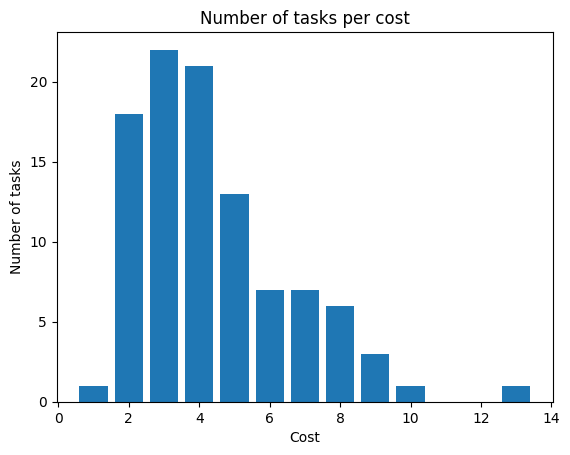

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

costs = [task.calc_cost() for task in solution.tasks]
cost_counts = Counter(costs)

plt.bar(cost_counts.keys(), cost_counts.values())
plt.xlabel('Cost')
plt.ylabel('Number of tasks')
plt.title('Number of tasks per cost')
plt.show()

## Analyze the score

Let's break down the score per constraint:

In [11]:
from timefold.solver import SolutionManager

solution_manager = SolutionManager.create(solver_factory)
score_analysis = solution_manager.analyze(solution)

And visualize it:

In [12]:
from IPython.core.display import HTML

html_content = f"<p style='font-size: x-large'>Score: {score_analysis.score}</p>"
html_content += "<ul>"
for constraint in score_analysis.constraint_map.values():
    html_content += f"<li>{constraint.constraint_name}: {constraint.score}</li>"
html_content += "</ul>"

HTML(html_content)

## Notice

This code isn't optimized for benchmarking or scaling.

To learn more about planning optimization, visit [docs.timefold.ai](https://docs.timefold.ai).